In [ ]:
# Step 1: Mount Drive & Unzip Dataset
from google.colab import drive
import zipfile, os

drive.mount('/content/drive')
zip_path = '/content/drive/MyDrive/verification.zip'
extract_to = '/content/verification'
with zipfile.ZipFile(zip_path, 'r') as z:
    z.extractall(extract_to)
# Dataset root (adjust if nested inside another folder)
DATA_ROOT = os.path.join(extract_to, 'train')

Mounted at /content/drive


In [ ]:
!pip install ultralytics

In [ ]:
# Step 2: Imports & Helper Definitions
import random
import numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, confusion_matrix, roc_curve
)
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import transforms, models
from PIL import Image

# --- EmbedNet Definition & Loader ---
class EmbedNet(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.backbone = models.resnet50(pretrained=False)
        self.backbone.fc = nn.Linear(self.backbone.fc.in_features, emb_dim)
    def forward(self, x):
        return self.backbone(x)

def load_embed(pt_path, embed_dim, device):
    model = EmbedNet(embed_dim).to(device)
    state = torch.load(pt_path, map_location=device)
    model.load_state_dict(state)
    model.eval()
    return model

In [ ]:
# Step 3: Load Models
from ultralytics import YOLO
# Classes: 0: Eye, 1: Tag, 2: Face, 3: Muzzle
yolo = YOLO('/content/drive/MyDrive/my_custom_model.pt')
yolo.conf = 0.25  # confidence threshold

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
EMBED_DIM = 128  # must match training
embed_model = load_embed('/content/drive/MyDrive/face_embed.pt', EMBED_DIM, DEVICE)

# Image transform for embedding
transform = transforms.Compose([
    transforms.Resize((160, 160)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
# Step 4: Detection & Embedding Functions
def crop_face(img_path):
    """Detects face region; returns full image if none found."""
    img = Image.open(img_path).convert('RGB')
    results = yolo.predict(source=np.array(img))[0]
    faces = []
    for *box, conf, cls in results.boxes.data.cpu().numpy():
        if int(cls) == 2:
            faces.append((*box, conf, cls))
    if not faces:
        return img
    x1, y1, x2, y2, _, _ = max(faces, key=lambda x: x[4])
    return img.crop((x1, y1, x2, y2))

def get_embedding(img_crop):
    """Generates embedding from cropped face image."""
    tensor = transform(img_crop).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        emb = embed_model(tensor)
    return emb.cpu().numpy().flatten()

In [ ]:
# Step 5: Prepare Data Splits & Pairs
def prepare_data(root_dir, test_size=0.2):
    sheep_dirs = {d.name: list(Path(root_dir, d.name).glob('*.jpg'))
                  for d in Path(root_dir).iterdir() if d.is_dir()}
    train_dirs, test_dirs = {}, {}
    # Split each class; classes with <2 images get no test samples
    for cls, files in sheep_dirs.items():
        if len(files) < 2:
            train_dirs[cls], test_dirs[cls] = files.copy(), []
        else:
            tr, te = train_test_split(files, test_size=test_size, random_state=42)
            train_dirs[cls], test_dirs[cls] = tr, te
    # Build genuine/imposter test pairs
    test_pairs = []
    valid_classes = [c for c, lst in test_dirs.items() if lst]
    for cls, files in test_dirs.items():
        for f in files:
            test_pairs.append((cls, f, 1))  # genuine label = 1
            imp = random.choice([c for c in valid_classes if c != cls])
            test_pairs.append((imp, f, 0))   # imposter label = 0
    return train_dirs, test_dirs, test_pairs

train_dirs, _, test_pairs = prepare_data(DATA_ROOT)

In [ ]:
# Step 6: Build Gallery (average embedding per class)
def build_gallery(train_dirs):
    gallery = {}
    for cls, imgs in train_dirs.items():
        if not imgs: continue
        embs = []
        for img in imgs:
            crop = crop_face(img)
            embs.append(get_embedding(crop))
        gallery[cls] = np.mean(embs, axis=0)
    return gallery

gallery = build_gallery(train_dirs)


0: 480x640 1 Eye, 1 Tag, 1 Face, 288.7ms
Speed: 30.0ms preprocess, 288.7ms inference, 25.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 Eye, 1 Face, 141.5ms
Speed: 5.1ms preprocess, 141.5ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 Eye, 1 Tag, 1 Face, 130.6ms
Speed: 4.1ms preprocess, 130.6ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

0: 640x480 1 Eye, 1 Face, 132.4ms
Speed: 6.0ms preprocess, 132.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)

0: 480x640 1 Eye, 1 Tag, 1 Face, 117.5ms
Speed: 4.3ms preprocess, 117.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 Eye, 1 Face, 117.2ms
Speed: 3.4ms preprocess, 117.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 Eye, 1 Face, 124.3ms
Speed: 4.9ms preprocess, 124.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x480 1 Eye, 1 Face, 144.7ms
Speed: 4.9m

In [ ]:
# Step 7: Score Test Pairs
labels, scores = [], []
for claimed, img_path, label in test_pairs:
    if claimed not in gallery:
        continue
    crop = crop_face(img_path)
    emb = get_embedding(crop)
    sim = cosine_similarity([emb], [gallery[claimed]])[0][0]
    scores.append(sim)
    labels.append(label)
labels = np.array(labels)
scores = np.array(scores)


0: 480x640 1 Eye, 1 Face, 173.0ms
Speed: 4.3ms preprocess, 173.0ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 Eye, 1 Face, 272.4ms
Speed: 3.8ms preprocess, 272.4ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 Tag, 1 Face, 162.1ms
Speed: 3.8ms preprocess, 162.1ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 Tag, 1 Face, 152.2ms
Speed: 4.0ms preprocess, 152.2ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 Eye, 1 Face, 150.0ms
Speed: 3.3ms preprocess, 150.0ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 Eye, 1 Face, 166.1ms
Speed: 3.3ms preprocess, 166.1ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 Eye, 1 Face, 116.7ms
Speed: 4.0ms preprocess, 116.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 Eye, 1 Face, 126.3ms
Speed: 4.1ms preprocess, 126.3ms i

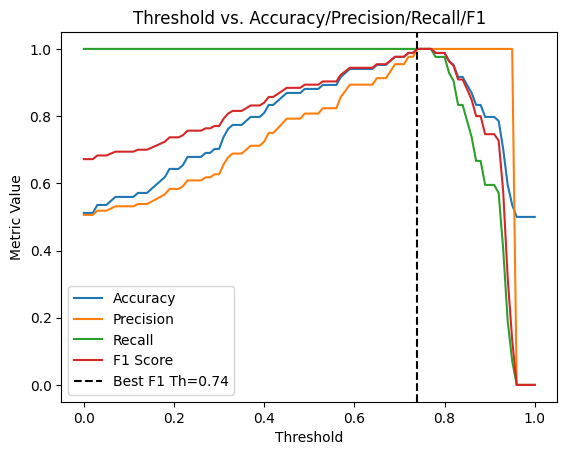

In [ ]:
# Step 8: Threshold Tuning & Multi-metric Curves
thresholds = np.linspace(0, 1, 101)
accs, precs, recs, f1s = [], [], [], []
for t in thresholds:
    preds = (scores >= t).astype(int)
    accs.append(accuracy_score(labels, preds))
    precs.append(precision_score(labels, preds, zero_division=0))
    recs.append(recall_score(labels, preds, zero_division=0))
    f1s.append(f1_score(labels, preds, zero_division=0))
best_idx = np.argmax(f1s)
best_thresh = thresholds[best_idx]

plt.figure()
plt.plot(thresholds, accs, label='Accuracy')
plt.plot(thresholds, precs, label='Precision')
plt.plot(thresholds, recs, label='Recall')
plt.plot(thresholds, f1s, label='F1 Score')
plt.axvline(best_thresh, color='k', linestyle='--', label=f'Best F1 Th={best_thresh:.2f}')
plt.xlabel('Threshold')
plt.ylabel('Metric Value')
plt.title('Threshold vs. Accuracy/Precision/Recall/F1')
plt.legend(loc='best')
plt.show()

In [ ]:
# Step 9: Compute Metrics at Best Threshold
best_preds = (scores >= best_thresh).astype(int)
acc = accuracy_score(labels, best_preds)
prec = precision_score(labels, best_preds)
rec = recall_score(labels, best_preds)
f1 = f1_score(labels, best_preds)
auroc = roc_auc_score(labels, scores)
aupr = average_precision_score(labels, scores)

print(f'Best Threshold: {best_thresh:.2f}')
print(f'Accuracy: {acc:.2%}')
print(f'Precision: {prec:.2%}')
print(f'Recall: {rec:.2%}')
print(f'F1 Score: {f1:.2%}')
print(f'AUROC: {auroc:.3f}')
print(f'AUPR: {aupr:.3f}')

Best Threshold: 0.74
Accuracy: 100.00%
Precision: 100.00%
Recall: 100.00%
F1 Score: 100.00%
AUROC: 1.000
AUPR: 1.000


<Figure size 640x480 with 0 Axes>

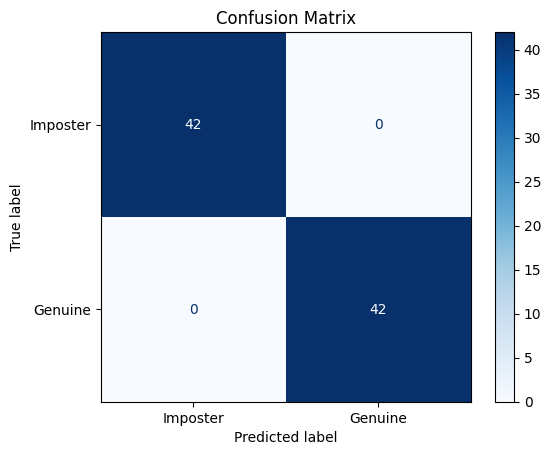

In [ ]:
# Step 10: Confusion Matrix Visualization
cm = confusion_matrix(labels, best_preds)
from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Imposter','Genuine'])
plt.figure()
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()


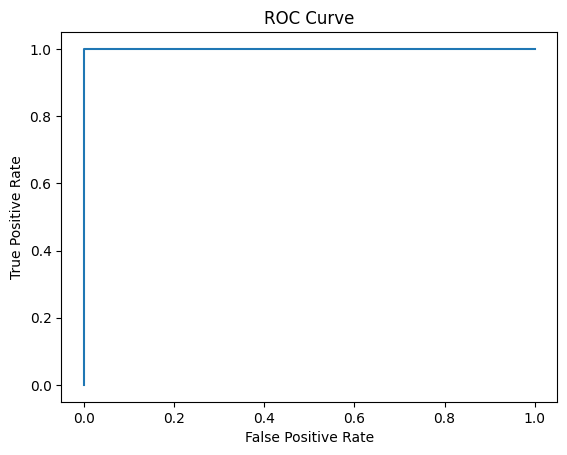

In [ ]:
# Step 11: ROC Curve
fpr, tpr, _ = roc_curve(labels, scores)
plt.figure()
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()